A notebook for guiding image capture and reflectance and stereo calibration with the OROCHI laboratory simulator.

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Overview

The steps are as follows. Note that dark image capture is reserved for the end, to minimise physical interactions with the cameras.

1. Reflectace Calibration Target Imaging
    - Prompt: Lens Cap removal, put calibration target in place
    - Cycle over cameras. For each camera:
        - Test the connection
        - load/configure the camera
        - get optimal exposure and check ROI
        - capture repeat images of the calibration target
        - save the images
        - save the exposures used
2. Geometric Calibration Target Imaging
    - Prompt: Lens Cap removal, put geometric calibration target in place
    - Cycle over cameras. For each camera:
        - Test the connection
        - load/configure the camera
        - get optimal exposure and check ROI
        - capture repeat images of the geometric calibration target
        - save the images
        - save the exposures used
3. Sample Imaging
    - as above, but with the sample replacing the calibration target
4. Dark Imaging
    - Prompt: Lens cap on / lights out
    - Cycle over cameras. For each camera:
        - check connection
            - Calibration darks:
                - load calibration exposure for given camera
                - set exposure
                - capture repeat frames
                - save frames
            - Sample darks:
                - as aove but load sample exposures instead
5. Processing to Reflectance

# Setup

Here we setup the IC object, load the camera configuration file, and connect to and initiate the OROCHI camera channels.

In [5]:
import orochi_sim_ctrl as osc

ic = osc.start_ic()
camera_config = osc.load_camera_config()
cameras = osc.connect_cameras(ic, camera_config)
osc.configure_cameras(cameras)

Warning - cameras not connected: {'Band8', 'Band1'}
Device 0 (DMK 33GX249 10910288) succesfully connected.
Device 1 (DMK 33GX249 10910273) succesfully connected.
Device 2 (DMK 33GX249 10910289) succesfully connected.
Device 4 (DMK 33GX249 10910291) succesfully connected.
Device 5 (DMK 33GX249 10910295) succesfully connected.
Device 7 (DMK 33GX249 23120778) succesfully connected.
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
Brightness Value set to 416
Contrast Value set to 0
Sharpness Value set to 0
Gamma Value set to 100
Gain Value set to 0.0
Gain Auto set to 0
Exposure Value set to 0.009999999776482582
Exposure Auto set to 1
Exposure Auto Reference set to 80
Exposure Auto Max Value set to 2.0
Exposure Auto Max Auto set to 0
Trigger Enable set to 0
Denoise Value set to 0
Flip Horizontal Enable set to 0
Flip Vertical Enable set to 0
Highlight Reduction Enable set to 0
Tone Mapping Enable set to 0
Strobe Enable set to 0
Auto Func

# Calibration Target Imaging

- Prompt: Lens Cap removal, put calibration target in place
- Cycle over cameras. For each camera:
    - get optimal exposure and check ROI
    - capture repeat images of the calibration target
    - save the images
    - save the exposures used

Check:
1. The calibration target is in place
2. Lens cap is removed

In [6]:
osc.prepare_reflectance_calibration(ic)

Find the optimal exposures for calibration target imaging.

In [13]:
calibration_exposures = osc.find_channel_exposures(cameras)

-----------------------------------
Device 0
-----------------------------------
Initiating search:
Exposure Value set to 0.009999999776482582
Exposure Auto set to 0
Trial 0:
Exposure current Value: 0.009998999536037445
Exposure Value set to 0.04166249930858612
Trial 1:
Exposure current Value: 0.04166200011968613
Exposure Value set to 0.17855143547058105
Trial 2:
Exposure current Value: 0.17855100333690643
Exposure Value set to 0.7439625263214111
Trial 3:
Exposure current Value: 0.7439619898796082
Exposure Value set to 3.099841594696045
Trial 4:
Exposure current Value: 3.0998411178588867
Exposure Value set to 12.91600513458252
Trial 5:
Exposure current Value: 12.91600513458252
Failure to satisfy tolerance. Exiting routine.
Exposure current Value: 12.91600513458252
-----------------------------------
-----------------------------------
Device 1
-----------------------------------
Initiating search:
Exposure Value set to 0.009999999776482582
Exposure Auto set to 0
Trial 0:
Exposure curre

Check the calibration target images.

-----------------------------------
Device 0
-----------------------------------
Exposure Value set to 12.91600513458252
Exposure Auto set to 0


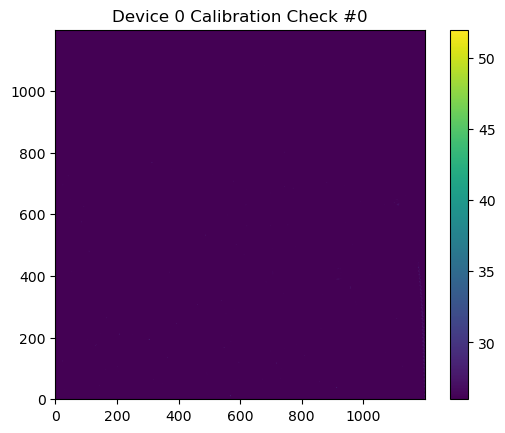

-----------------------------------
-----------------------------------
Device 1
-----------------------------------
Exposure Value set to 17.73933982849121
Exposure Auto set to 0


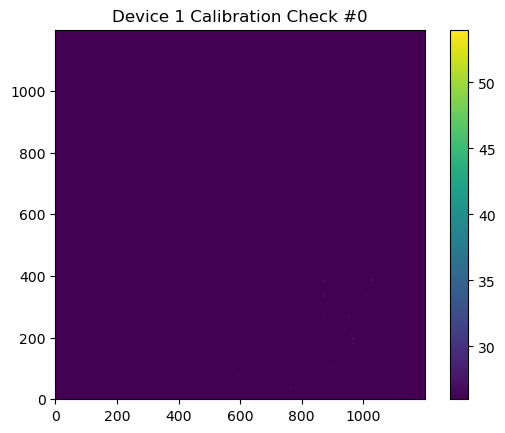

-----------------------------------
-----------------------------------
Device 2
-----------------------------------
Exposure Value set to 13.675621032714844
Exposure Auto set to 0


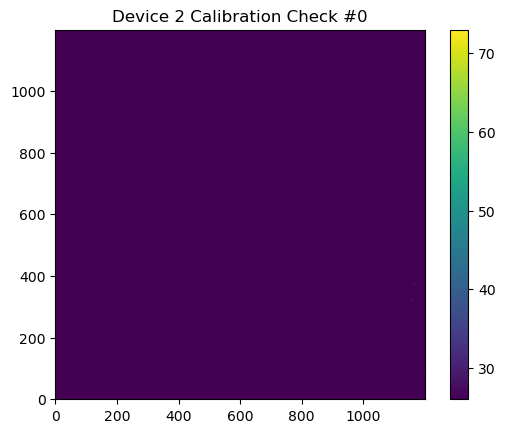

-----------------------------------
-----------------------------------
Device 4
-----------------------------------
Exposure Value set to 14.456477165222168
Exposure Auto set to 0


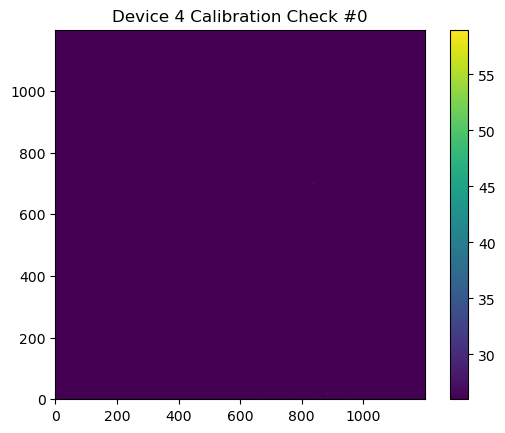

-----------------------------------
-----------------------------------
Device 5
-----------------------------------
Exposure Value set to 44.39022445678711
Exposure Auto set to 0


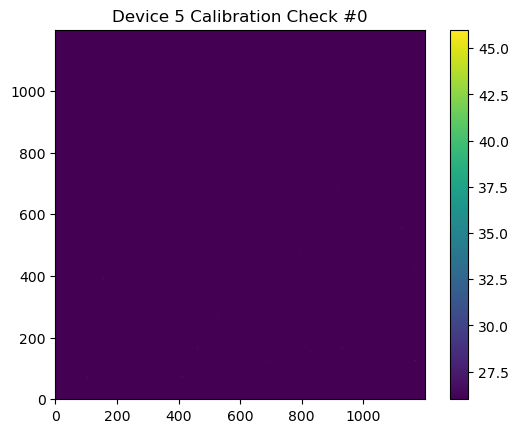

-----------------------------------
-----------------------------------
Device 7
-----------------------------------
Exposure Value set to 18.2772274017334
Exposure Auto set to 0


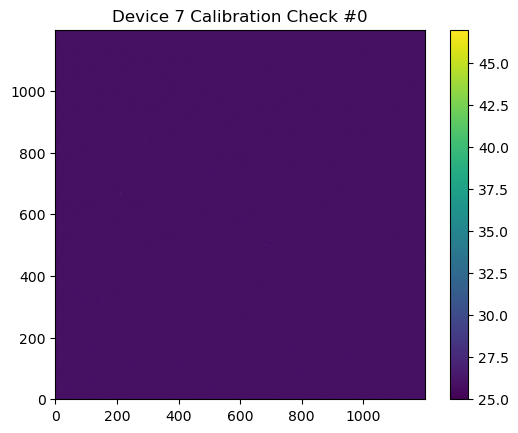

-----------------------------------


In [15]:
osc.capture_channel_images(
    cameras, 
    calibration_exposures, 
    subject='Calibration Check', 
    roi=True, 
    show_img=True)

Capture 10 repeat images of the calibration target in each channel.

In [17]:
osc.capture_channel_images(
    cameras, 
    calibration_exposures, 
    subject='reflectance_calibration', 
    repeats=10,
    roi=False, 
    show_img=False,
    save_img=True)

-----------------------------------
Device 0
-----------------------------------
Exposure Value set to 12.91600513458252
Exposure Auto set to 0
Exposure current Value: 12.91600513458252
Image 0 written to reflectance_calibration\0_650\650_0_img.tif
Exposure current Value: 12.91600513458252
Image 1 written to reflectance_calibration\0_650\650_1_img.tif
Exposure current Value: 12.91600513458252
Image 2 written to reflectance_calibration\0_650\650_2_img.tif
Exposure current Value: 12.91600513458252
Image 3 written to reflectance_calibration\0_650\650_3_img.tif
Exposure current Value: 12.91600513458252
Image 4 written to reflectance_calibration\0_650\650_4_img.tif
Exposure current Value: 12.91600513458252
Image 5 written to reflectance_calibration\0_650\650_5_img.tif
Exposure current Value: 12.91600513458252
Image 6 written to reflectance_calibration\0_650\650_6_img.tif
Exposure current Value: 12.91600513458252
Image 7 written to reflectance_calibration\0_650\650_7_img.tif
Exposure current

Write the exposures to file.

In [19]:
osc.record_exposures(cameras, calibration_exposures, 'reflectance_calibration')

# Geometric Calibration Target Imaging

- Prompt: Lens Cap removal, put geometric calibration target in place
- Cycle over cameras. For each camera:
    - get optimal exposure and check ROI
    - capture repeat images of the geometric calibration target
    - save the images
    - save the exposures used

Check:
1. The geometric target is in place
2. Lens cap is removed

In [20]:
osc.prepare_geometric_calibration(ic)

Find the optimal exposures for geometric calibration target imaging.

In [22]:
geometric_exposures = osc.find_channel_exposures(cameras, roi=False)

-----------------------------------
Device 0
-----------------------------------
Initiating search:
Exposure Value set to 0.009999999776482582
Exposure Auto set to 0
Trial 0:
Exposure current Value: 0.009998999536037445
Exposure Value set to 0.04166249930858612
Trial 1:
Exposure current Value: 0.04166200011968613
Exposure Value set to 0.17359167337417603
Trial 2:
Exposure current Value: 0.1735910028219223
Exposure Value set to 0.7037473320960999
Trial 3:
Exposure current Value: 0.7037469744682312
Exposure Value set to 2.8530282974243164
Trial 4:
Exposure current Value: 2.8530280590057373
Exposure Value set to 11.566329956054688
Trial 5:
Exposure current Value: 11.566329002380371
Exposure Value set to 46.89052200317383
Failure to satisfy tolerance. Exiting routine.
Exposure current Value: 46.89051818847656
-----------------------------------
-----------------------------------
Device 1
-----------------------------------
Initiating search:
Exposure Value set to 0.009999999776482582
Expo

Check the geometric calibration target images.

-----------------------------------
Device 0
-----------------------------------
Exposure Value set to 46.89051818847656
Exposure Auto set to 0


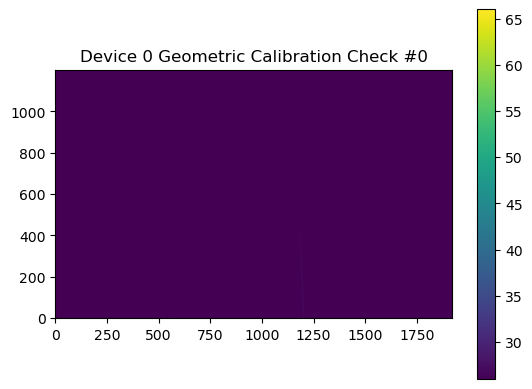

-----------------------------------
-----------------------------------
Device 1
-----------------------------------
Exposure Value set to 37.986846923828125
Exposure Auto set to 0


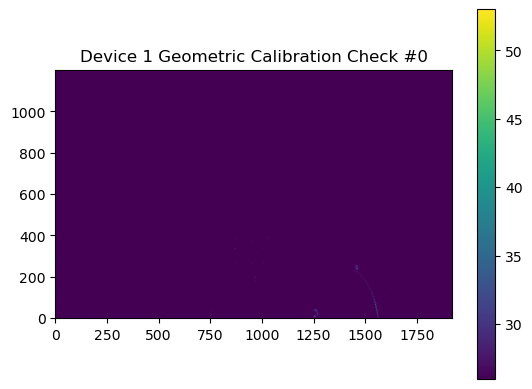

-----------------------------------
-----------------------------------
Device 2
-----------------------------------
Exposure Value set to 38.848785400390625
Exposure Auto set to 0


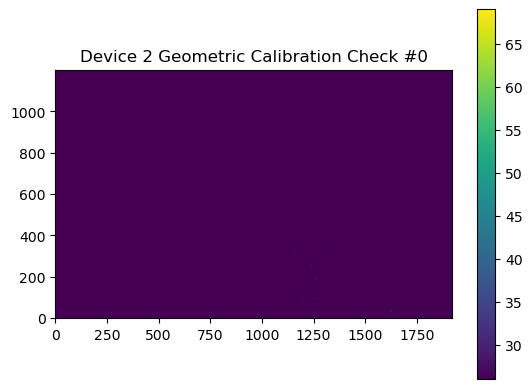

-----------------------------------
-----------------------------------
Device 4
-----------------------------------
Exposure Value set to 35.961360931396484
Exposure Auto set to 0


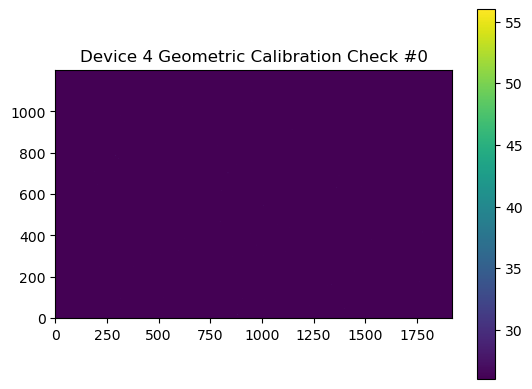

-----------------------------------
-----------------------------------
Device 5
-----------------------------------
Exposure Value set to 28.519058227539062
Exposure Auto set to 0


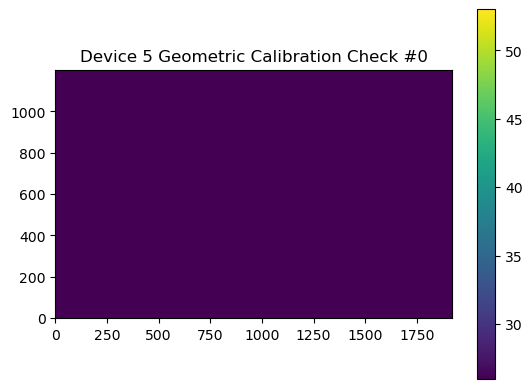

-----------------------------------
-----------------------------------
Device 7
-----------------------------------
Exposure Value set to 12.557204246520996
Exposure Auto set to 0


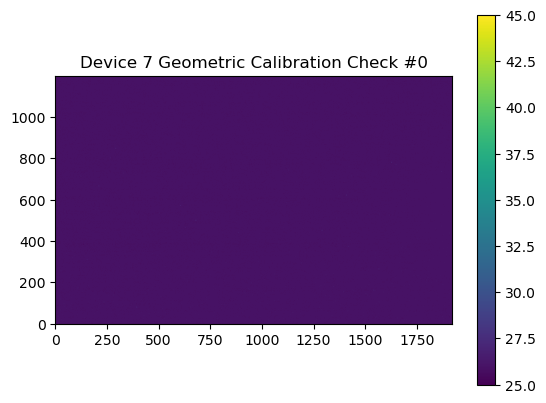

-----------------------------------


In [23]:
osc.capture_channel_images(
    cameras, 
    geometric_exposures, 
    subject='Geometric Calibration Check', 
    roi=False, 
    show_img=True)

Capture 10 repeat images of the geometric calibration target in each channel.

In [24]:
osc.capture_channel_images(
    cameras, 
    geometric_exposures, 
    subject='geometric_calibration', 
    repeats=10,
    roi=False, 
    show_img=False,
    save_img=True)

-----------------------------------
Device 0
-----------------------------------
Exposure Value set to 46.89051818847656
Exposure Auto set to 0
Exposure current Value: 46.89051818847656
Image 0 written to ..\data\geometric_calibration\0_650\650_0_img.tif
Exposure current Value: 46.89051818847656
Image 1 written to ..\data\geometric_calibration\0_650\650_1_img.tif
Exposure current Value: 46.89051818847656
Image 2 written to ..\data\geometric_calibration\0_650\650_2_img.tif
Exposure current Value: 46.89051818847656
Image 3 written to ..\data\geometric_calibration\0_650\650_3_img.tif
Exposure current Value: 46.89051818847656
Image 4 written to ..\data\geometric_calibration\0_650\650_4_img.tif
Exposure current Value: 46.89051818847656
Image 5 written to ..\data\geometric_calibration\0_650\650_5_img.tif
Exposure current Value: 46.89051818847656
Image 6 written to ..\data\geometric_calibration\0_650\650_6_img.tif
Exposure current Value: 46.89051818847656
Image 7 written to ..\data\geometric_

Write the exposures to file.

In [25]:
osc.record_exposures(cameras, geometric_exposures, 'geometric_calibration')

# Sample Imaging

- Prompt: Lens Cap removal, put sample in place
- Cycle over cameras. For each camera:
    - get optimal exposure and check ROI
    - capture repeat images of the sample
    - save the images
    - save the exposures used

Check:
1. The sample is in place
2. Lens cap is removed

In [ ]:
osc.prepare_sample_imaging(ic)

Find the optimal exposures for sample imaging.

In [ ]:
sample_exposures = osc.find_exposures(cameras, roi=True)

Check the sample images.

In [ ]:
osc.capture_channel_images(
    cameras, 
    sample_exposures, 
    subejct='Sample Check', 
    roi=False, 
    show_img=True)

Capture 10 repeat images of the geometric calibration target in each channel.

In [ ]:
osc.capture_channel_images(
    cameras, 
    sample_exposures, 
    subject='sample', 
    repeats=10,
    roi=False, 
    show_img=False,
    save_img=True)

Write the exposures to file.

In [ ]:
osc.record_exposures(cameras, sample_exposures, 'sample')

# Dark Frame Imaging

Now we use the recorded exposures to capture dark frames.

Check:
1. Lens cap is in place

In [26]:
osc.prepare_dark_acquisition(ic)

Capture Reflectance Calibration Dark Frames.

In [27]:
osc.capture_channel_images(
    cameras, 
    calibration_exposures, 
    subject='reflectance_calibration', 
    img_type='drk',
    repeats=10,
    roi=False, 
    show_img=False,
    save_img=True)

-----------------------------------
Device 0
-----------------------------------
Exposure Value set to 12.91600513458252
Exposure Auto set to 0
Exposure current Value: 12.91600513458252
Image 0 written to ..\data\reflectance_calibration\0_650\650_0_drk.tif
Exposure current Value: 12.91600513458252
Image 1 written to ..\data\reflectance_calibration\0_650\650_1_drk.tif
Exposure current Value: 12.91600513458252
Image 2 written to ..\data\reflectance_calibration\0_650\650_2_drk.tif
Exposure current Value: 12.91600513458252
Image 3 written to ..\data\reflectance_calibration\0_650\650_3_drk.tif
Exposure current Value: 12.91600513458252
Image 4 written to ..\data\reflectance_calibration\0_650\650_4_drk.tif
Exposure current Value: 12.91600513458252
Image 5 written to ..\data\reflectance_calibration\0_650\650_5_drk.tif
Exposure current Value: 12.91600513458252
Image 6 written to ..\data\reflectance_calibration\0_650\650_6_drk.tif
Exposure current Value: 12.91600513458252
Image 7 written to ..\d

Capture Geometric Calibration Dark Frames.

In [28]:
osc.capture_channel_images(
    cameras, 
    geometric_exposures, 
    subject='geometric_calibration', 
    img_type='drk',
    repeats=10,
    roi=False, 
    show_img=False,
    save_img=True)

-----------------------------------
Device 0
-----------------------------------
Exposure Value set to 46.89051818847656
Exposure Auto set to 0
Exposure current Value: 46.89051818847656
Image 0 written to ..\data\geometric_calibration\0_650\650_0_drk.tif
Exposure current Value: 46.89051818847656
Image 1 written to ..\data\geometric_calibration\0_650\650_1_drk.tif
Exposure current Value: 46.89051818847656
Image 2 written to ..\data\geometric_calibration\0_650\650_2_drk.tif
Exposure current Value: 46.89051818847656
Image 3 written to ..\data\geometric_calibration\0_650\650_3_drk.tif
Exposure current Value: 46.89051818847656
Image 4 written to ..\data\geometric_calibration\0_650\650_4_drk.tif
Exposure current Value: 46.89051818847656
Image 5 written to ..\data\geometric_calibration\0_650\650_5_drk.tif
Exposure current Value: 46.89051818847656
Image 6 written to ..\data\geometric_calibration\0_650\650_6_drk.tif
Exposure current Value: 46.89051818847656
Image 7 written to ..\data\geometric_

Capture Sample Dark Frames.

In [ ]:
osc.capture_channel_images(
    cameras, 
    sample_exposures, 
    subject='sample', 
    img_type='drk',
    repeats=10,
    roi=False, 
    show_img=False,
    save_img=True)

# Functions

Here we iniatilise the functions, used in the previous notebooks, for the camera control.

In [ ]:
import tisgrabber as tis
from pathlib import Path
import ctypes
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import pandas as pd

# get the location of the tisgrabber_x64.dll file
tis_dir = Path(tis.__file__).resolve().parents[0]
tis_dll = str(Path(tis_dir, 'tisgrabber_x64.dll'))

# Load/Initiate the tisgrabber library
ic = ctypes.cdll.LoadLibrary(tis_dll)
tis.declareFunctions(ic)
ic.IC_InitLibrary(0)

Define a function for setting the camera properties.

In [ ]:
def set_property(property: str, element: str, value, interface: str, hGrabber):
    
    if interface == 'Range':
        set_property_func = ic.IC_SetPropertyValue
        value = ctypes.c_int(value)
    elif interface == 'AbsoluteValue':
        set_property_func = ic.IC_SetPropertyAbsoluteValue
        value = ctypes.c_float(value)
    elif interface == 'AbsoluteValueRange':
        set_property_func = ic.IC_SetPropertyAbsoluteValueRange
        value = ctypes.c_float(value)
    elif interface == 'Switch':
        set_property_func = ic.IC_SetPropertySwitch
        value = ctypes.c_int(value)
    elif interface == 'MapStrings':
        set_property_func = ic.IC_SetPropertyMapStrings
        value = ctypes.c_char(value)
    elif interface == 'Button':
        set_property_func = ic.IC_SetPropertyOnePush
        value = ctypes.c_int(value)

    ret = set_property_func(
            hGrabber, 
            property.encode("utf-8"),
            element.encode("utf-8"), 
            value)
    if ret == 1:
        print(f'{property} {element} set to {value.value}')
    elif ret == -2:
        raise ValueError('No video capture device opened')
    elif ret == -4:
        raise ValueError(f'{property} is not available')
    elif ret == -5:
        raise ValueError(f'{property} item {element} is not available')
    elif ret == -6:
        raise ValueError(f'{property} {element} has no interface')

Define a function to set all camera properties:

In [ ]:
def set_defaults(grabber, exposure=1.0/100, auto_exposure=1, black_level=26):
    black_level = black_level*2**4
    set_property('Brightness', 'Value', black_level, 'Range', grabber) # brightness is Black Level in DN for the 12-bit range of the detector. Default is to 10% of detector range, for linearity
    set_property('Contrast', 'Value', 0, 'Range', grabber)
    set_property('Sharpness', 'Value', 0, 'Range', grabber)    
    set_property('Gamma', 'Value', 100, 'Range', grabber)
    set_property('Gain', 'Value', 0.0, 'AbsoluteValue', grabber)
    set_property('Gain', 'Auto', 0, 'Switch', grabber)
    set_property('Exposure', 'Value', exposure, 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', auto_exposure, 'Switch', grabber)
    set_property('Exposure', 'Auto Reference', 80, 'Range', grabber)
    set_property('Exposure', 'Auto Max Value', 2.0, 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto Max Auto', 0, 'Switch', grabber)
    set_property('Trigger', 'Enable', 0, 'Switch', grabber)
    set_property('Denoise', 'Value', 0, 'Range', grabber)
    set_property('Flip Horizontal', 'Enable', 0, 'Switch', grabber)
    set_property('Flip Vertical', 'Enable', 0, 'Switch', grabber)
    set_property('Highlight Reduction', 'Enable', 0, 'Switch', grabber)
    set_property('Tone Mapping', 'Enable', 0, 'Switch', grabber)
    set_property('Strobe', 'Enable', 0, 'Switch', grabber)
    set_property('Auto Functions ROI', 'Enabled', 0, 'Switch', grabber)

Define a function for getting image settings:

In [ ]:
def get_image_info(grabber):
    width = ctypes.c_long()
    height = ctypes.c_long()
    bits = ctypes.c_long()
    col_fmt = ctypes.c_int()

    ic.IC_GetImageDescription(grabber, width, height,
                            bits, col_fmt)


    bpp = int(bits.value / 8.0)
    buffer_size = width.value * height.value * bits.value

    return width.value, height.value, buffer_size, bpp

Define a function for capturing an image and returning it as an numpy array:

In [ ]:
def image_capture(grabber, camera=None, roi=False):

    ic.IC_StartLive(grabber,1)
    ic.IC_SnapImage(grabber, 2000) == tis.IC_SUCCESS
    ic.IC_StopLive(grabber,1)

    width, height, buffer_size, bpp = get_image_info(grabber)

    # Get the image data
    imagePtr = ic.IC_GetImagePtr(grabber)

    imagedata = ctypes.cast(imagePtr,
                            ctypes.POINTER(ctypes.c_ubyte *
                                        buffer_size))

    # Create the numpy array
    image = np.ndarray(buffer=imagedata.contents,
                    dtype=np.uint8,
                    shape=(height,
                            width,
                            bpp))

    if roi:
        x = camera['roix']
        y = camera['roiy']
        w = camera['roiw']
        h = camera['roih']
        image = image[x:x+w,y:y+h,0]
    else:
        image = image[:,:,0]
    return image

Define a function to look at the image:

In [ ]:
def show_image(img_arr, title):
    plt.imshow(img_arr, origin='lower')
    plt.title(title)
    plt.colorbar()

Define and call a function for getting the last used exposure:

In [ ]:
def get_property(property: str, element: str, interface: str, hGrabber):

    container = ctypes.c_float()
    ret = ic.IC_GetPropertyAbsoluteValue(
            hGrabber, 
            tis.T(property), 
            tis.T("Value"), container)
    if ret == 1:
        # print(f'{property} current {element}: {container.value}')
        return container.value
    elif ret == -2:
        raise ValueError('No video capture device opened')
    elif ret == -4:
        raise ValueError('Property item is not available')
    elif ret == -5:
        raise ValueError('Property item element is not available')
    elif ret == -6:
        raise ValueError('Requested element has no interface')
    return container.value

Implement exposure seeking function:

In [ ]:
def find_exposure(grabber, camera, init_t_exp=1.0/100, target=150, n_hot=10, tol=1, limit=5, roi=True):
    # initialise while loop
    searching = True
    trial_n = 0

    # ensure exposure setting is manual
    print('Initiating search:')
    set_property('Exposure', 'Value', init_t_exp, 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)

    while searching == True:
        print(f'Trial {trial_n}:')
        img_arr = image_capture(grabber, camera, roi) # capture the image
        k = 1 - n_hot/img_arr.size
        k_quantile = np.round(np.quantile(img_arr, k)) # evaluate the quantile
        success = target - k_quantile <= tol # check against target
        
        if success == True:
            print(f'Success after {trial_n} trials')
            t_exp = get_property('Exposure', 'Value', 'AbsoluteValue', grabber)
            searching = False # update searcing or continue
            return t_exp

        t_exp_scale = target / k_quantile # get the scaling factor
        last_t_exp = get_property('Exposure', 'Value', 'AbsoluteValue', grabber) # get the current exposure
        new_t_exp = t_exp_scale * last_t_exp# scale the exposure
        set_property('Exposure', 'Value', new_t_exp, 'AbsoluteValue', grabber) # update the camera settings
        trial_n+=1 # increment the counter
        failure = trial_n > limit

        if failure == True:
            print(f'Failure to satisfy tolerance. Exiting routine.')
            t_exp = get_property('Exposure', 'Value', 'AbsoluteValue', grabber)
            searching = False
            return t_exp
    
    return None

Save an image:

In [ ]:
def save_tiff(name, target, img_type, img_arr, grabber, camera):

    exposure = get_property('Exposure', 'Value', 'AbsoluteValue', grabber)
    metadata={
        'camera': camera['number'],
        'serial': camera['serial'],
        'cwl': camera['cwl'],
        'fwhm': camera['fwhm'],
        'f-number': camera['fnumber'],
        'f-length': camera['flength'],
        'exposure': exposure,
        'image-type': img_type, # image or dark frame or averaged stack
        'target': target
    }
    cwl_str = str(int(camera['cwl']))
    channel = str(camera['number'])+'_'+cwl_str
    target_dir = Path(target, channel)
    target_dir.mkdir(parents=True, exist_ok=True)
    filename = cwl_str+'_'+name+'_'+img_type
    img_file =str(Path(target_dir, filename).with_suffix('.tif'))
    # write camera properties to TIF using ImageJ metadata
    tiff.imwrite(img_file, img_arr, imagej=True, metadata=metadata)
    print(f'Image {name} written to {img_file}')

Configure device lost callback code:

In [ ]:
class CallbackUserdata(ctypes.Structure):
    """ Example for user data passed to the callback function. 
    """
    def __init__(self, ):
        self.unsused = ""
        self.devicename = ""
        self.connected = False


def frameReadyCallback(hGrabber, pBuffer, framenumber, pData):
    # Maybe do something here.
    return


def deviceLostCallback(hGrabber, userdata):
    """ This a device lost callback function. Called, if the camera disconnects. 
    This function runs in the Grabber thread, not in the main thread.
    :param: hGrabber: This is the real pointer to the grabber object. Do not use.
    :param: pData : Pointer to additional user data structure
    """
    userdata.connected = False
    print("Device {} lost".format(userdata.devicename))

frameReadyCallbackfunc = ic.FRAMEREADYCALLBACK(frameReadyCallback)
userdata = CallbackUserdata()
devicelostcallbackfunc = ic.DEVICELOSTCALLBACK(deviceLostCallback)

# Looping Over Multiple Channels

We loop over multiple cameras by defining a list of cameras, and defining  dictionary, indexed by this list, giving the camera descriptions required to load and control each camera.

We load these from the camera_config.csv file, generated with the camera_congif.ipynb procedure.

In [ ]:
cameras = pd.read_csv('camera_config.csv', index_col=0)

In [ ]:
cameras = cameras.T.astype({
    'number': 'int', 
    'serial': str, 
    'fnumber': float, 
    'flength': float, 
    'cwl': float, 
    'fwhm': float, 
    'width': int, 
    'height': int, 
    'roix': int, 
    'roiy': int, 
    'roiw': int, 
    'roih': int}).T

Get a list of the cameras available, notify of missing cameras, and connect to the available cameras.

In [ ]:
def connect_cameras(cameras):
    connected_cameras = []
    devicecount = ic.IC_GetDeviceCount()

    for i in range(0, devicecount):
        uniquename = tis.D(ic.IC_GetUniqueNamefromList(i))
        connected_cameras.append(uniquename)
    missing_cameras = set(list(cameras.keys())) - set(connected_cameras)
    if len(missing_cameras) > 0:
        print(f'Warning - cameras not connected: {missing_cameras}')
    grabbers = {}
    for camera in connected_cameras:
        cam_name = camera
        cam_num = cameras[camera]['number']
        grabber = ic.IC_CreateGrabber()
        grabbers[camera] = grabber
        ic.IC_OpenDevByUniqueName(grabber, tis.T(cam_name))

        userdata.devicename = f'{cam_num} ({cam_name})'
        userdata.connected = True

        ic.IC_SetCallbacks(grabber,
                        frameReadyCallbackfunc, None,
                        devicelostcallbackfunc, userdata)

        # check the device is connected
        if ic.IC_IsDevValid(grabber):
            print(f'Device {cam_num} ({cam_name}) succesfully connected.')
        else:
            err_string = f'Camera {cam_num} ({cam_name}) did not connect - check connection and try again'
            ic.IC_MsgBox( tis.T(err_string),tis.T("Connection Error"))
    print(f'{len(grabbers)} cameras connected.')
    return grabbers

We now have a list of camera grabbers, and will recieve messages if any of these connections are lost.

In [ ]:
grabbers = connect_cameras(cameras)
bad_count = 0
while len(grabbers) == 0:
    err_string = f'No cameras connected - check connection and try again'
    ic.IC_MsgBox( tis.T(err_string),tis.T("Connection Error"))
    grabbers = connect_cameras(cameras)
    bad_count +=1
    if bad_count >= 5:
        raise ConnectionError('No cameras connect. Abort script and try again.')


# Camera Configuration

In [ ]:
for grabber in grabbers:
    cam_num = cameras[grabber]['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_defaults(grabbers[grabber])
    print('-----------------------------------')

# Calibration Target Imaging

- Prompt: Lens Cap removal, put calibration target in place
- Cycle over cameras. For each camera:
    - get optimal exposure and check ROI
    - capture repeat images of the calibration target
    - save the images
    - save the exposures used

Check:
1. The calibration target is in place
2. Lens cap is removed

In [ ]:
ic.IC_MsgBox(tis.T('Check Calibration Target is in place'), tis.T('Imaging Calibration Target'))
ic.IC_MsgBox(tis.T('Check Lens Caps are removed'), tis.T('Imaging Calibration Target'))

Get optimal exposures for the calibration target:

In [ ]:
calibration_exposures = {}
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    calibration_t_exp = find_exposure(grabber, camera)
    calibration_exposures[cam_name] = calibration_t_exp
    print('-----------------------------------')

Check the images:

In [ ]:
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', calibration_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    img_arr = image_capture(grabber, camera, roi=False)
    title = f'Device {cam_num} Calibration Check'
    show_image(img_arr,title)
    peak_dn = img_arr.max()
    print(f'Peak Value: {peak_dn} DN')
    print('-----------------------------------')

In [ ]:
ic.IC_MsgBox(tis.T('Calibration Target ROIs and Exposures Ok?'), tis.T('Imaging Calibration Target'))

Capture the repeat images:

In [ ]:
n = 10
target = 'calibrationtest'
img_type = 'img'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

Write the exposure to file for quick read access:

In [ ]:
for cam_name in grabbers:
    cwl_str = str(int(camera['cwl']))
    channel = str(camera['number'])+'_'+cwl_str
    target_dir = Path(target, channel)
    target_dir.mkdir(parents=True, exist_ok=True)
    filename = Path(target_dir, 'exposure_seconds.txt')
    with open(filename, 'w') as f:
            t_exp = str(calibration_exposures[cam_name])
            f.write(t_exp)

# Geometric Calibration Target Imaging

- Prompt: Lens Cap removal, put geometric calibration target in place
- Cycle over cameras. For each camera:
    - get optimal exposure and check ROI
    - capture repeat images of the geometric calibration target
    - save the images
    - save the exposures used

Check:
1. The geometric calibration target is in place
2. Lens cap is removed

In [ ]:
ic.IC_MsgBox(tis.T('Check Geometric Calibration Target is in place'), tis.T('Imaging Geometric Calibration Target'))
ic.IC_MsgBox(tis.T('Check Lens Caps are removed'), tis.T('Imaging Geometric Calibration Target'))

In [ ]:
geometric_exposures = {}
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    geometric_t_exp = find_exposure(grabber, camera, roi=False)
    geometric_exposures[cam_name] = geometric_t_exp
    print('-----------------------------------')

Check the images:

In [ ]:
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', geometric_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    img_arr = image_capture(grabber, camera, roi=False)
    title = f'Device {cam_num} Geometric Calibration Check'
    show_image(img_arr,title)
    peak_dn = img_arr.max()
    print(f'Peak Value: {peak_dn} DN')
    print('-----------------------------------')

In [ ]:
ic.IC_MsgBox(tis.T('Geometric Calibration Target ROIs and Exposures Ok?'), tis.T('Imaging Calibration Target'))

Capture the repeat images:

In [ ]:
n = 10
target = 'geometrictest'
img_type = 'img'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

Write the exposure to file for quick read access:

In [ ]:
for cam_name in grabbers:
    cwl_str = str(int(camera['cwl']))
    channel = str(camera['number'])+'_'+cwl_str
    target_dir = Path(target, channel)
    target_dir.mkdir(parents=True, exist_ok=True)
    filename = Path(target_dir, 'exposure_seconds.txt')
    with open(filename, 'w') as f:
            t_exp = str(geometric_exposures[cam_name])
            f.write(t_exp)

# Sample Imaging

- Prompt: Lens Cap removal, put sample in place
- Cycle over cameras. For each camera:
    - get optimal exposure and check ROI
    - capture repeat images of the sample
    - save the images
    - save the exposures used

Check:
1. The sample is in place
2. Lens cap is removed

In [ ]:
ic.IC_MsgBox(tis.T('Check Sample is in place'), tis.T('Imaging Sample'))
ic.IC_MsgBox(tis.T('Check Lens Caps are removed'), tis.T('Imaging Sample'))

In [ ]:
sample_exposures = {}
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    sample_t_exp = find_exposure(grabber, camera)
    sample_exposures[cam_name] = sample_t_exp
    print('-----------------------------------')

Check the images:

In [ ]:
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', sample_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    img_arr = image_capture(grabber, camera, roi=False)
    title = f'Device {cam_num} Sample Check'
    show_image(img_arr,title)
    peak_dn = img_arr.max()
    print(f'Peak Value: {peak_dn} DN')
    print('-----------------------------------')

In [ ]:
ic.IC_MsgBox(tis.T('Sample ROIs and Exposures Ok?'), tis.T('Imaging Sample'))

Capture the repeat images:

In [ ]:
n = 10
target = 'sampletest'
img_type = 'img'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

Write the exposure to file for quick read access:

In [ ]:
for cam_name in grabbers:
    cwl_str = str(int(camera['cwl']))
    channel = str(camera['number'])+'_'+cwl_str
    target_dir = Path(target, channel)
    target_dir.mkdir(parents=True, exist_ok=True)
    filename = Path(target_dir, 'exposure_seconds.txt')
    with open(filename, 'w') as f:
            t_exp = str(sample_exposures[cam_name])
            f.write(t_exp)

# Dark Frame Imaging

Now we use the recorded exposures to capture dark frames.

Check:
1. Lens cap is in place

In [ ]:
ic.IC_MsgBox(tis.T('Check Lens Cap is in place'), tis.T('Dark Imaging'))

Calibration dark images:

In [ ]:
n = 10
target = 'calibrationtest'
img_type = 'drk'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', calibration_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

In [ ]:
n = 10
target = 'geometrictest'
img_type = 'drk'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', geometric_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

Sample Dark Images:

In [ ]:
n = 10
target = 'sampletest'
img_type = 'drk'
for cam_name in grabbers:
    grabber = grabbers[cam_name]
    camera = cameras[cam_name]
    cam_num = camera['number']
    print('-----------------------------------')
    print(f'Device {cam_num}')
    print('-----------------------------------')
    set_property('Exposure', 'Value', sample_exposures[cam_name], 'AbsoluteValue', grabber)
    set_property('Exposure', 'Auto', 0, 'Switch', grabber)
    for i in range(n):
        img_arr = image_capture(grabber)
        save_tiff(str(i), target, img_type, img_arr, grabber, camera)

This completes the capture of images and dark frames for all cameras.

In [ ]:
ic.IC_MsgBox(tis.T('Sequence Complete. Disconnecting Cameras'), tis.T('Sequence Complete'))

for cam_name in grabbers:
    grabber = grabbers[cam_name]
    ic.IC_ReleaseGrabber(grabber)

Next, we will access these images for reflectance processing.